## Analysis and Transformation of Data

In [2]:
import numpy as np
import pandas as pd
import statsmodels as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt

from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.linear_model import LinearRegression

### Data Exploration

In [3]:
tuna_df = pd.read_csv(r'/Users/roopabharadwaj/Documents/CMU/mini_4/Machine Learning/Final project/consolidated_tuna_data_clean.csv')

In [4]:
tuna_df['dateInt']=tuna_df['year'].astype(str) + tuna_df['month'].astype(str).str.zfill(2)
tuna_df['Date'] = pd.to_datetime(tuna_df['dateInt'], format='%Y%m')

In [5]:
tuna_df.set_index('Date',inplace=True)
tuna_df.tail()

,year,month,ocean__temp_anomaly__00N_30N,ocean__total_error__00N_30N,ocean__high_error_variance__00N_30N,ocean__low_error_variance__00N_30N,ocean__bias_error_variance__00N_30N,ocean__diag_var_1__00N_30N,ocean__diag_var_2__00N_30N,ocean__diag_var_3__00N_30N,...,import_price_index_fish_shellfish,global_price_of_shrimp_x,global_price_of_shrimp_y,domestic_air_cargo_volume,atlantic_air_cargo_volume,latam_air_cargo_volume,pacific_air_cargo_volume,international_air_cargo_volume,total_air_cargo_volume,dateInt
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-01,2020,9,0.541057,0.008818,0.002324,0.000011,0.006483,0.148124,0.179720,0.031596,...,134.2,6.790090,6.790090,"1,638.44",603.432,106.610,936.439,"3,360.55","6,645.48",202009
2020-10-01,2020,10,0.510070,0.006911,0.000592,0.000011,0.006308,0.172130,0.176726,0.015000,...,136.7,6.876044,6.876044,"1,716.10",647.558,119.734,988.02,"3,692.89","7,164.30",202010
2020-11-01,2020,11,0.429951,0.006529,0.000384,0.000011,0.006135,0.177790,0.177967,0.015000,...,136.5,7.204598,7.204598,"1,653.30",608.019,122.899,999.561,"3,783.29","7,167.07",202011
2020-12-01,2020,12,0.420380,0.007155,0.000583,0.000011,0.006561,0.177329,0.178771,0.015000,...,137.9,7.810975,7.810975,"1,881.07",564.612,124.409,"1,015.13","3,599.97","7,185.19",202012
2021-01-01,2021,1,0.346833,0.007199,0.000485,0.000011,0.006703,0.183191,0.209245,0.026054,...,141.5,7.829473,7.829473,"1,604.91",565.108,123.120,947.415,"3,559.51","6,800.06",202101


In [7]:
tuna_df.isnull().sum()

year                                   0
month                                  0
ocean__temp_anomaly__00N_30N           0
ocean__total_error__00N_30N            0
ocean__high_error_variance__00N_30N    0
                                      ..
latam_air_cargo_volume                 0
pacific_air_cargo_volume               0
international_air_cargo_volume         0
total_air_cargo_volume                 0
dateInt                                0
Length: 434, dtype: int64

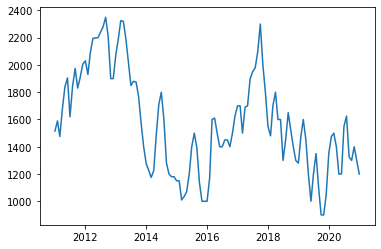

In [8]:
#SkipJack Tuna price over the years
plt.plot(tuna_df.skipjack_tuna_price)
plt.show()

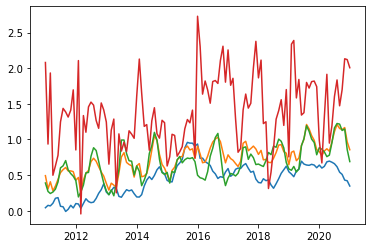

In [9]:
#Ocean temperatures at various locations
plt.plot(tuna_df.ocean__temp_anomaly__00N_30N)
plt.plot(tuna_df.ocean__temp_anomaly__20N_90N)
plt.plot(tuna_df.ocean__temp_anomaly__30N_60N)
plt.plot(tuna_df.ocean__temp_anomaly__60N_90N)
plt.show()

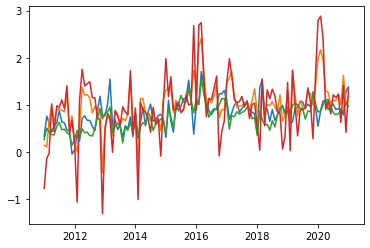

In [10]:
#Land temperatures at various locations
plt.plot(tuna_df.land__temp_anomaly__00N_30N)
plt.plot(tuna_df.land__temp_anomaly__00N_90N)
plt.plot(tuna_df.land__temp_anomaly__20S_20N)
plt.plot(tuna_df.land__temp_anomaly__30N_60N)
plt.show()

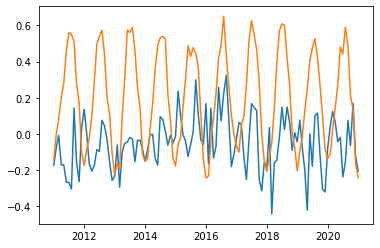

In [11]:
#Wind components
plt.plot(tuna_df.average_10_metre_u_wind_component)
plt.plot(tuna_df.average_10_metre_v_wind_component)
plt.show()

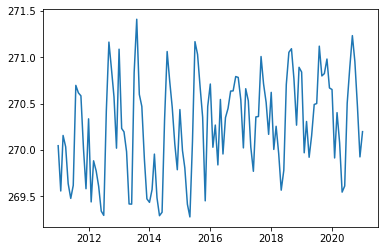

In [12]:
#Surface sea temperatures
plt.plot(tuna_df.minimum_sea_surface_temperature)
#plt.plot(tuna_df.average_sea_surface_temperature)
#plt.plot(tuna_df.maximum_sea_surface_temperature)
plt.show()

## Decomposing our time series

One of the most common analysis for time series is decomposing it into multiple parts. The parts we can divide a time series into are: level, trend, seasonality and noise, all series contain level and noise but seasonality and trend are not always present (there will be more analysis for this in two parts).

This 4 parts can combine either additively or multiplicatively into the time series.<br>

***Additive Model*** <br>
y(t) = Level + Trend + Seasonality + Noise <br>
Additives models are linear. Trend is linear and seasonality has constant frequency and amplitude. Change is constant over time <br>

***Multiplicative model*** <br>
y(t) = Level * Trend * Seasonality * Noise <br>
Multiplicatives models are nonlinear,trend is curved and seasonality is not constant. Change is not constant over time

Decomposing is used to analyse the time series. Identify each one of the different parts of the time series and its behaviour, each of the components may affect your models in different ways.

Most time series are a combination of a additive model and a multiplicate model, is hard to identify real world time series into one single model.

**Automatic time series decomposition** <br>
Statsmodel python library provides a function seasonal_compose() to automatically decompose a time series, we still need to specify wether the model is additive or multiplicative. We will use multiplicative as our quick peak at the time series shows linear trend.

<Figure size 4000x1600 with 0 Axes>

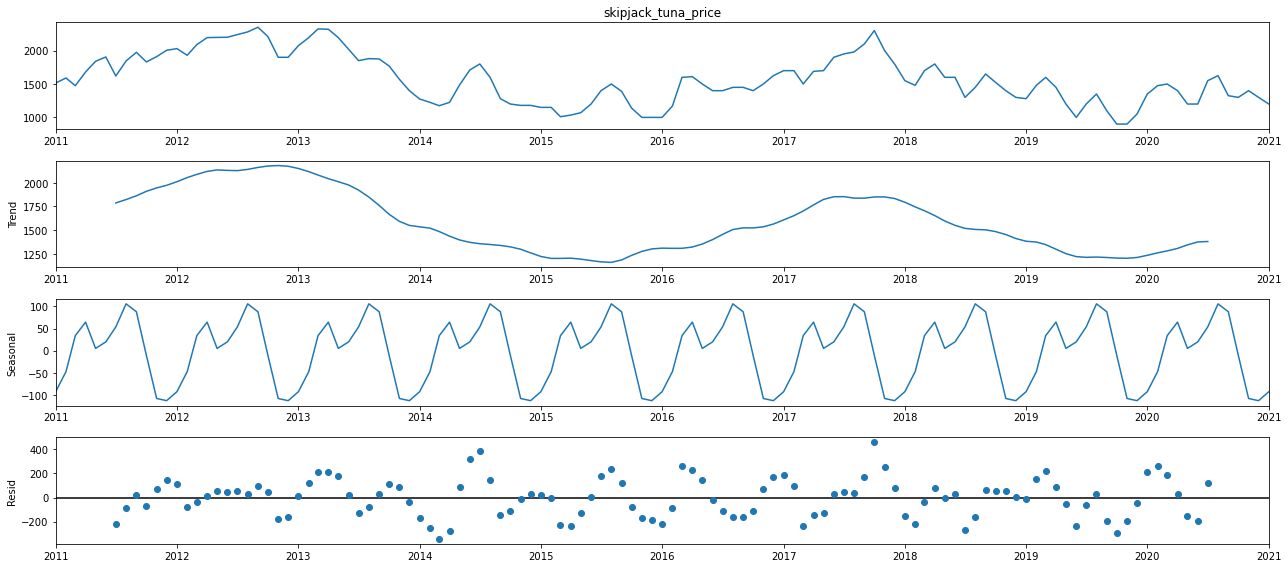

In [13]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = tuna_df.skipjack_tuna_price[:365]
result = seasonal_decompose(series, model='additive')
result.plot()
pass

### Level <br>

Level simply means the current value of the series once we remove trend, seasonality and the random noise. This are the true values that come from the series itself and we will try to predict with our models. Most of the models will benefit the more our time series is composed by the level and not trends/seasonality/noise.  <br>

### Trend <br>
A trend is observed when there is an increasing or decreasing slope observed in the time series. A trend is a smooth, general, long-term, average tendency. It is not always necessary that the increase or decrease is in the same direction throughout the given period of time. <br>

Trend can be removed from time series data (and data in the future) as a data preparation and cleaning exercise. This is common when using statistical methods for time series forecasting, but does not always improve results when using machine learning models.<br>

In practice, identifying a trend in a time series can be a subjective process as we are never sure if contains seasonalities or noise to it. <br>

Now we will try some methods to check for trend in our series:<br>
Automatic decomposing <br>
Moving average <br>
Fit a linear regression model to identify trend <br>

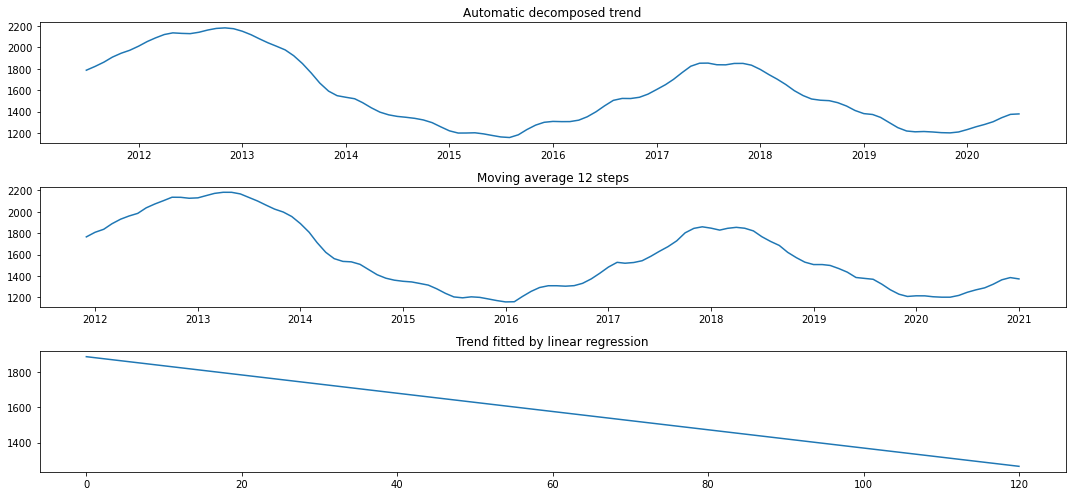

In [14]:
fig = plt.figure(figsize=(15, 7))
layout = (3,2)
pm_ax = plt.subplot2grid(layout, (0,0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1,0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2,0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = tuna_df.skipjack_tuna_price.rolling(12).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")


X = [i for i in range(0, len(tuna_df.skipjack_tuna_price))]
X = np.reshape(X, (len(X), 1))
y = tuna_df.skipjack_tuna_price.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

We can see our series has a strong trend, results from both the automatic decomposition and the moving average look more like a seasonality efect+random noise than a trend. 

**Manual methods to find seasonalities** <br>

We can also try to generate a model to find the seasonalities for us. One of the most common to use is a simple polynomial model.

/Users/roopabharadwaj/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:627: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/roopabharadwaj/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


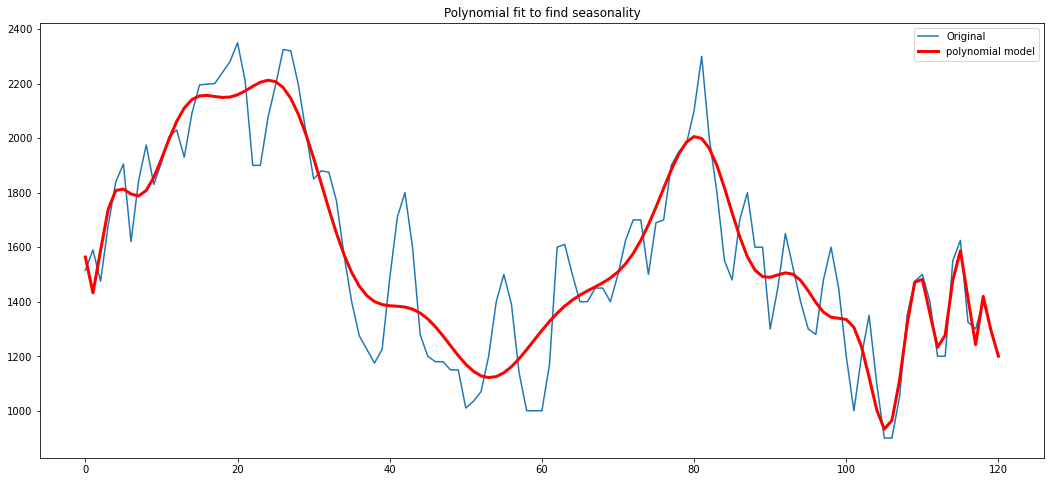

In [15]:
#Fix xticks to show dates
# fit polynomial: x^2*b1 + x*b2 + ... + bn
series = tuna_df.skipjack_tuna_price.values
X = [i%365 for i in range(0, len(series))]
y = series
degree = 100
coef = np.polyfit(X, y, degree)
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
# plot curve over original data
plt.plot(series,label='Original')
plt.plot(curve, color='red', linewidth=3,label='polynomial model')
plt.legend()
plt.title("Polynomial fit to find seasonality")
plt.show()

We can see how the model performs to find a seasonality. Fits pretty well to our data. 

## Stationarity <br>
Stationarity is an important characteristic of time series. A time series is stationarity if it has constant mean and variance over time. Most models work only with stationary data as this makes it easier to model. Not all time series are stationary but we can transform them into stationary series in different ways.

Often, stock prices are not a stationary process, since we might see a growing trend, or its volatility might increase over time (meaning that variance is changing).

***Check for sationarity***

**Autocorrelation and Partial autocorrelation plots**

Autocorelation plots show how correlated are values at time t with the next values in time t+1,t+2,..t+n. If the data would be non-stationary the autocorrelation values will be highly correlated with distant points in time showing possible seasonalities or trends.

Stationary series autocorrelation values will quickly decrease over time t. This shows us that information is carried over time and then the series should will not constant over time.

/Users/roopabharadwaj/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


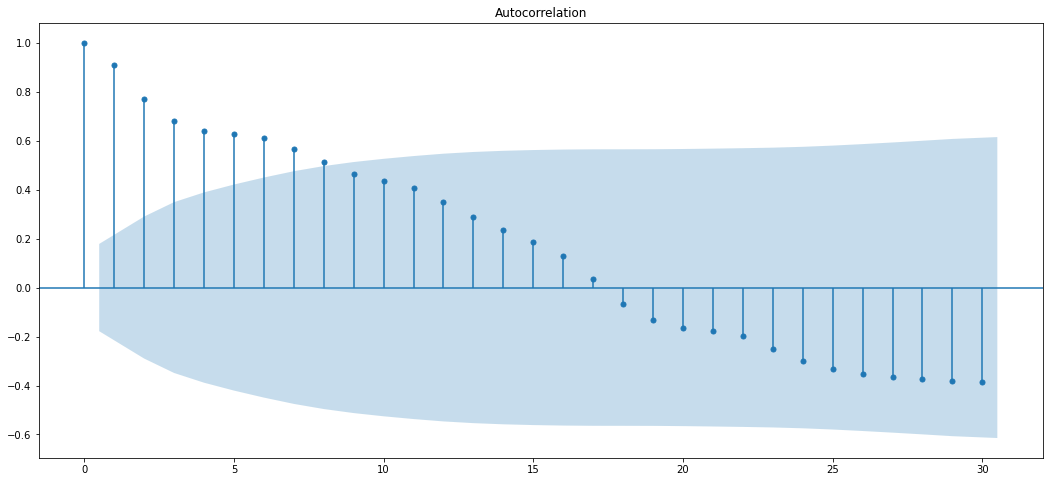

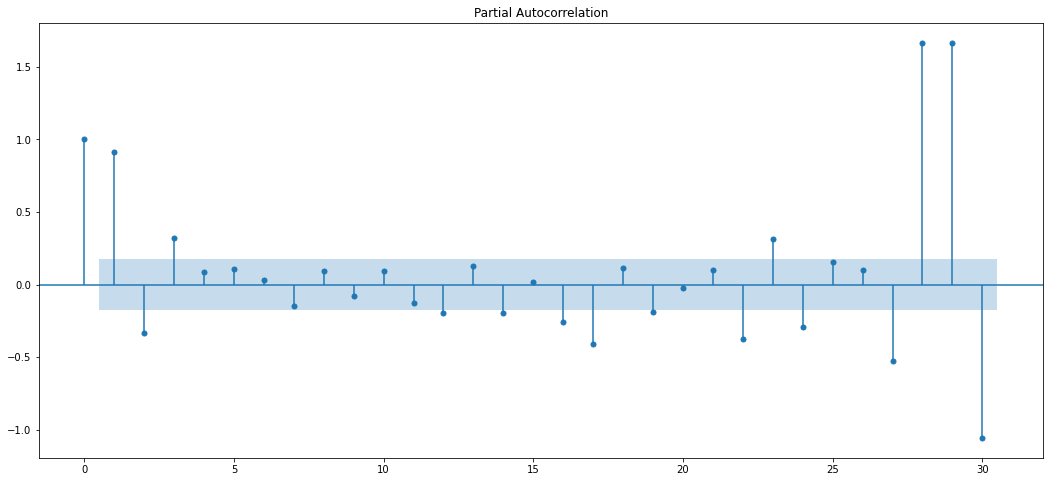

In [16]:
plot_acf(series, lags = 30)
plot_pacf(series, lags = 30)
plt.show()

**Augmented Dickey-Fuller test**

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

***Null Hypothesis (H0)***: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure. 
***Alternate Hypothesis (H1)***: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure. We interpret this result using the p-value from the test. 

A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).
p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary. p-value <= 0.05: 
Reject the null hypothesis (H0), the data does not have a unit root and is stationary. 

In [17]:
X = tuna_df.skipjack_tuna_price.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.129036
p-value: 0.233000
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580


/Users/roopabharadwaj/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


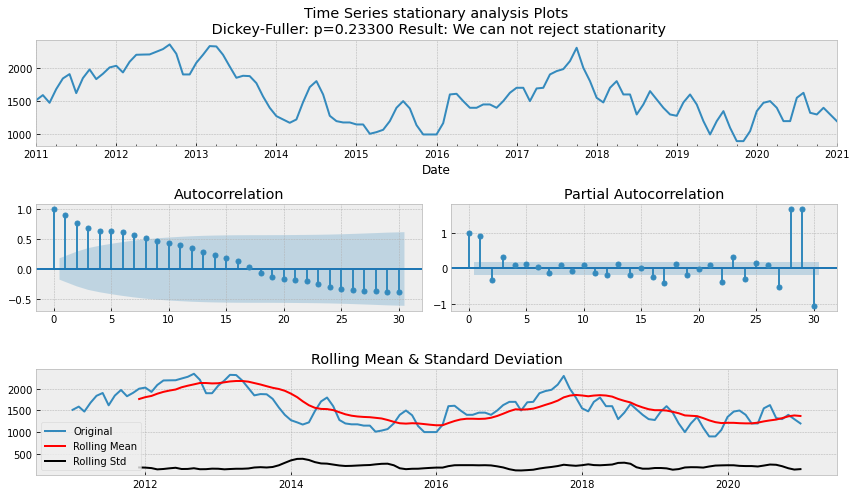

In [81]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        mean_std_ax = plt.subplot2grid(layout, (2,0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject stationarity" if p_value<=0.05 else "We can not reject stationarity"
        ts_ax.set_title('Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value,hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
        rolmean = tuna_df..rolling(window=12).mean()
        rolstd = tuna_df.skipjack_tuna_price.rolling(window=12).std()

        #Plot rolling statistics:
        orig = plt.plot(tuna_df.skipjack_tuna_price,label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        
        
tsplot(tuna_df.skipjack_tuna_price, lags=30)

With a p value of 0.23, we need to apply some methods to make the series stationary.

Coming back to the stationary definition, what makes our current series non stationary?

**Trend**- The mean for our series is not constant, it increases over time and <br>
**Seasonality** - The values of our series vary over time with an specific pattern that repeats over time, this is called seasonalities (Example: spike of people flying on the 24th of December). <br>
We now present some methods to remove or smooth this trend and seasonality components

## Making Time Series Stationary

**Log scale transformation**

Applying a log scale transform to a time series could also help remove the series dependence on time. <br>
This transform is done by substracting the previous obesvation to the current one. <br>
LogScaleTransform(t)= Log(t)

Text(0.5, 1.0, 'Log scale transformation into original series')

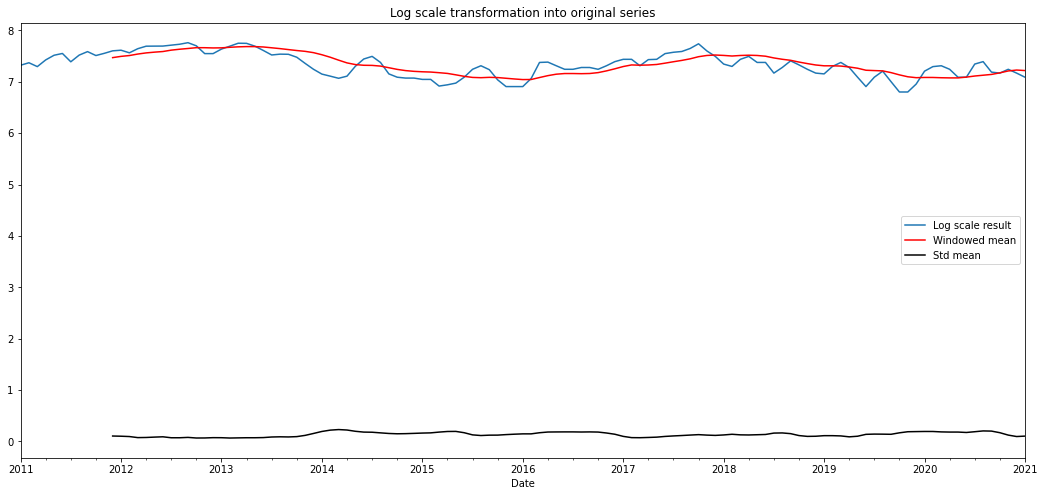

In [18]:
ts_log = np.log(tuna_df.skipjack_tuna_price)
ts_log.plot(label='Log scale result')
ts_log.rolling(window=12).mean().plot(color='red', label='Windowed mean')
ts_log.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()
plt.title('Log scale transformation into original series')

**Smoothing** <br>
We have seen the moving mean as a measure to check stationarity, we can also apply this windows to our series to remove seasonality.

With smoothing we will take rolling averages over periods of time. Is a bit tricky to choose the best windows.

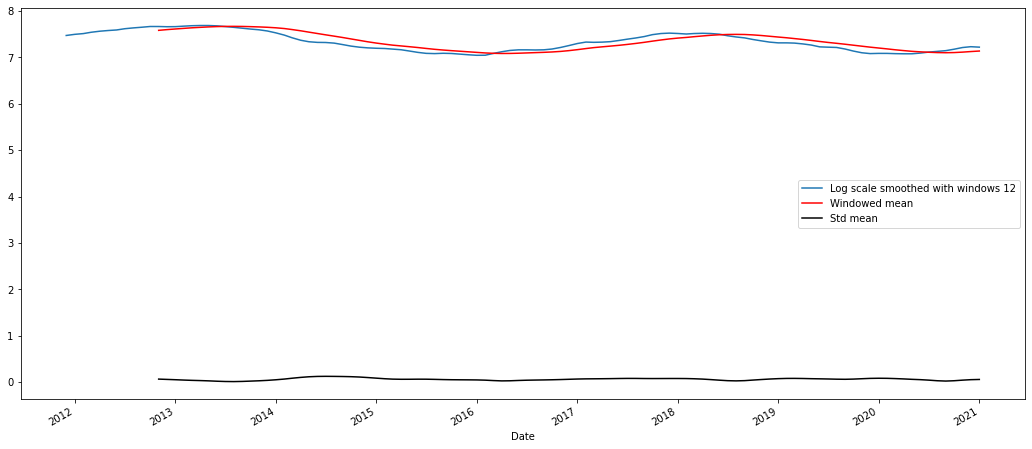

In [19]:
avg = pd.Series(ts_log).rolling(12).mean()
plt.plot(avg, label='Log scale smoothed with windows 12')
avg.rolling(window=12).mean().plot(color='red', label='Windowed mean')
avg.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()

We can combine it with our previous log scale and apply differencing

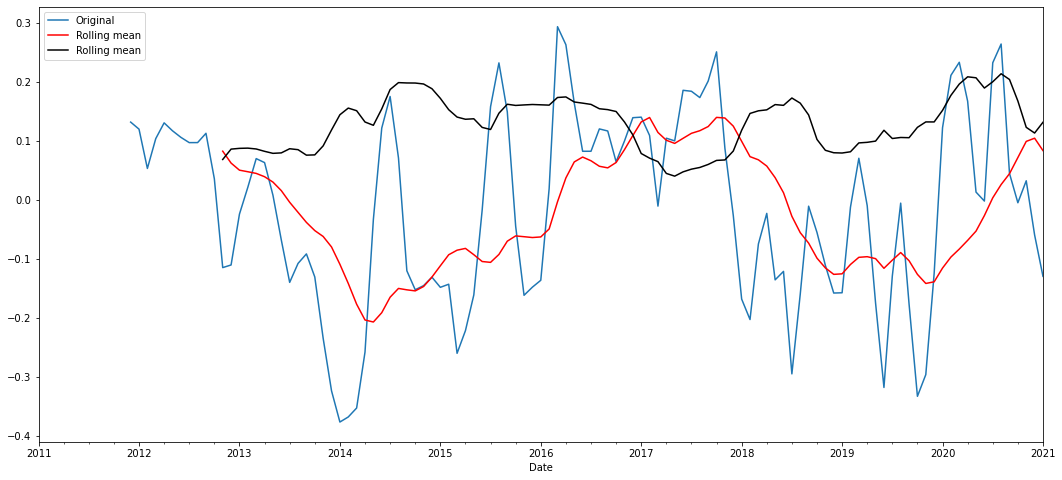

In [20]:
ts_log_moving_avg_diff = ts_log - avg

ts_log_moving_avg_diff.plot(label='Original')
ts_log_moving_avg_diff.rolling(12).mean().plot(color='red',label="Rolling mean")
ts_log_moving_avg_diff.rolling(12).std().plot(color='black',label="Rolling mean")
plt.legend(loc='best')